# Modtran Tape7 Data Analysis

In [1]:
###
import os
import numpy as np
import pandas as pd
from scipy.interpolate import  interp1d

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

## Modtran Runs

Several different path geometries were investigated, all for the same atmospheric model. The atmospheric model used here is not important, it merely serves as common model. For reference, this model has custom vertical profiles with max altitude of 30.03~km, with high ground temperature and 10 km visibility Navy Maritime aerosol, and specifies the standard Modtran Desert albedo.

Note that Modtran does not assume any vertical profiles values higher than the highest given tape5 profile data, longer/higher paths are truncated to the upper limit in the profile.

The path geometries with identifiers are shown in Figure~\ref{fig:pathgeometry01}.

![](images/pathgeometry01.png)

|Run |ID|Path | H1 | H2 | Zenith | 
| --| ---| ---| ---|---|--|
|obs |o |slant path | 12.027|0.027| 118.8|
|low |l |slant path | 0.037 | 0.027| 118.8|
|med |m |slant path | 3 | 0.027| 118.8|
|sun |s |slant path to space | 0.027|30.03 | 21.33 |
|upp |u |slant path to space | 30.03|0.027  |180 |

The Modtran tape6 files reported the follwing path calculations:

obs

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =   12.02700 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =   24.98077 KM
              ECA     =    0.19685 DEG
              BCKZEN  =   61.37906 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.01778 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0

low 

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    0.03700 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =    0.02076 KM
              ECA     =    0.00016 DEG
              BCKZEN  =   61.20023 DEG
              HMIN    =    0.02700 KM
              BENDING =   -0.00006 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0



med 

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    3.00000 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =    6.17544 KM
              ECA     =    0.04866 DEG
              BCKZEN  =   61.24339 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00527 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


sun  (highest layer at 30.03 km)

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    0.02700 KM
              H2ALT   =   30.03000 KM
              OBSZEN  =   21.33000 DEG
              HRANGE  =   32.19863 KM
              ECA     =    0.10485 DEG
              BCKZEN  =  158.76947 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00538 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


upp  (highest layer at 30.03 km)

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =   30.03000 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  180.00000 DEG
              HRANGE  =   30.00300 KM
              ECA     =    0.00000 DEG
              BCKZEN  =    0.00000 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00000 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


In [2]:
###
dicPaths = {
'o':['[o] obs H1=12, H2=0.027, OBSZEN=118, HRANGE=25 km','g'],
'l':['[l] low H1=0.037, H2=0.027, OBSZEN=118, HRANGE=0.02 km','y'],
'm':['[m] low H1=3, H2=0.027, OBSZEN=118, HRANGE=6.2 km','c'],
's':['[s] sun H1=0.027, H2=30, OBSZEN=21, HRANGE=32.2 km','r'],
'u':['[u] upp H1=30, H2=0.027, OBSZEN=180, HRANGE=30 km','b']
}

In [4]:
## to define a function to load and interpolate the tape7 files
def loadinter(filename,wli):
    tape7 = rymodtran.loadtape7(filename, ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT',
                                          'PTH_THRML','THRML_SCT','SURF_EMIS','SOL_SCAT','SING_SCAT','TOTAL_RAD'] )

    waven = tape7[:,0]

    # transmittance observer to ground
    tau = np.exp(-tape7[:,2])
    intfn = interp1d(1e4/waven,tau)
    tau = intfn(wli).reshape(-1,1)
    
    # convert from cm2 to m2
    refsoln = tape7[:,1]*1e4
    solobsn = tape7[:,3]*1e4
    grndrfltn = tape7[:,4]*1e4
    drctrfltn = tape7[:,5]*1e4

    # convert to per micron spectral density and interpolate to new vector
    (wavel, refsol) = ryutils.convertSpectralDensity(waven, refsoln, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, solobs) = ryutils.convertSpectralDensity(waven, solobsn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, grndrflt) = ryutils.convertSpectralDensity(waven, grndrfltn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, drctrflt) = ryutils.convertSpectralDensity(waven, drctrfltn, 'nl',outspecdomainFix=True,outspecdomain=wli)
    
    
    
    
    
    return wavel, tau, refsol, solobs, grndrflt, drctrflt


The `FREQ`, `REF_SOL`,`DEPTH`,`SOL@OBS`,`GRND_RFLT`,`DRCT_RFLT` columns are read from the Modtran tape7 files, for each of the paths.  The Modtran spectral albedo for Desert was extracted from the Modtran data folders and read here.  Next,  the Wehrli standard extraterrestrial (TOA) solar irradiance values are also read from a data file (https://www.nrel.gov/grid/solar-resource/spectra-wehrli.html). Finally a very simple blackbody model is used to calculate the model for TOA extraterrestrial solar irradiance.

In [6]:
## to load all the data
wli = np.linspace(1e4/33330.00, 1e4/10000.00,300)

# lod the three cases of modtran runa
wavelo, tauo, refsolo, solobso, grndrflto, drctrflto = loadinter('data/obs/tape5.tp7',wli)
wavell, taul, refsoll, solobsl, grndrfltl, drctrfltl = loadinter('data/low/tape5.tp7',wli)
wavelm, taum, refsolm, solobsm, grndrfltm, drctrfltm = loadinter('data/med/tape5.tp7',wli)
wavels, taus, refsols, solobss, grndrflts, drctrflts = loadinter('data/sun/tape5.tp7',wli)
wavelu, tauu, refsolu, solobsu, grndrfltu, drctrfltu = loadinter('data/upp/tape5.tp7',wli)

albedod = np.loadtxt('data/albedo.dat')
intfn = interp1d(albedod[:,0],albedod[:,1])
albedo = intfn(wavelo).reshape(-1,1)

wehrli85d = np.loadtxt('data/wehrli85.txt',skiprows=3)
intfn = interp1d(wehrli85d[:,0]/1000.,wehrli85d[:,1]*1000.)
wehrli85 = intfn(wavelo).reshape(-1,1) 

Tsun = 5850
Esun = 2.17e-5 * ryplanck.planck(wavelo,Tsun,'el') 

The path transmittance values are shown in Figure~\ref{fig:pathtransmittance}.  For each line in the plot is shown the heights `H1` and `H2`, the `OBSZEN` azimuth angle in degrees and the path `HRANGE` path length.

The relative ratios of transmittance values agree with absorber amounts expectations.

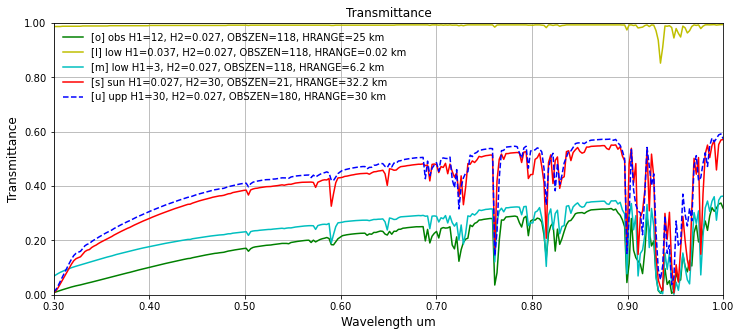

In [7]:
## to plot transmittance data
p = ryplot.Plotter(1, 1, 1, figsize=(12,5))
p.plot(1,wavelo,tauo,label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
p.plot(1,wavelo,taul,label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
p.plot(1,wavelo,taum,label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
p.plot(1,wavelo,taus,label=[dicPaths['s'][0]],plotCol=dicPaths['s'][1])
p.plot(1,wavelo,tauu,label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1],linestyle=['--'],
       ptitle='Transmittance',xlabel='Wavelength um',ylabel='Transmittance',
       pltaxis=[0.3,1,0,1],maxNX=8);


Figure~\ref{fig:SOLOBS} shows `SOL@OBS`: the  irradiance at the obsever, as well as the Wehrli and simple blackbody TOA irradiance values.

Note that the two cases with high altitude `H1` values (o and u) have irradiance values close to the TOA irradiance.  We can therefore conclude that `SOL@OBS` includes the path transmittance from the sun to the observer at `H1`.

In [ ]:
## to plot SOL@OBS data
r = ryplot.Plotter(1, 1, 1, figsize=(15,7))

# r.plot(1,wavelo,solobso*taus,label=['solobso*taus'],plotCol='m')
r.plot(1,wavelo,solobso,label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
r.plot(1,wavelo,solobsl,label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
r.plot(1,wavelo,solobsm,label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
r.plot(1,wavelo,solobss,label=[dicPaths['s'][0]],plotCol=dicPaths['s'][1],linestyle=['--'])
r.plot(1,wavelo,solobsu,label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1],linestyle=['--'])
r.plot(1,wavelo,Esun,plotCol='k',label=[f'Scaled {Tsun} K blackbody'])
r.plot(1,wavelo,wehrli85,plotCol='m',label=[f'Wehrli 1985 standard'],
       ptitle='SOL@OBS Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
       pltaxis=[0.3,1,0,2200],maxNX=8);

Figure~\ref{fig:REFSOL} shows that `REFSOL` appears to be the unity-albedo ground-reflected solar irradiance at `H1`.  This is 
$$\textrm{REFSOL} = \tau_\textrm{sun}\tau_\textrm{path} \textrm{E}_\textrm{extra-terr}
$$
Upward looking paths (such as `sun`) do not provide relevant `REFSOL` values and is not considered here.
There is a reasonably good match  for all the cases between the Modtran results (solid colour lines) and the first-principles calculation using Wehrli and the Modtran transmittance values (black dashed lines).

In [ ]:
## to plot REFSOL data

r = ryplot.Plotter(1, 2, 2, figsize=(15,10))

r.plot(1,wavelo,refsoll,label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
r.plot(1,wavelo,wehrli85*taus*taul,label=['wehrli85 * taus * taul'],plotCol='k',linestyle=['--'],
    ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
    pltaxis=[0.3,1,0,1000],maxNX=8);

r.plot(2,wavelo,refsolm,label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
r.plot(2,wavelo,wehrli85*taus*taum,label=['wehrli85*taus*taum'],plotCol='k',linestyle=['--'],
    ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
    pltaxis=[0.3,1,0,1000],maxNX=8);

r.plot(3,wavelo,refsolo,label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
r.plot(3,wavelo,wehrli85*taus*tauo,label=['wehrli85 * taus * tauo'],plotCol='k',linestyle=['--'],
    ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
    pltaxis=[0.3,1,0,1000],maxNX=8);

r.plot(4,wavelo,refsolu,label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
r.plot(4,wavelo,wehrli85*taus*tauu,label=['wehrli85 * taus * tauu'],plotCol='k',linestyle=['--'],
    ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
    pltaxis=[0.3,1,0,1000],maxNX=8);



Figure~\ref{fig:DRCTRFLT} shows that `DRCT RFLT` appears to be the apparent ground radiance at `H2` as observed from `H1`, with non-unity-albedo ground-reflected solar (only) irradiance. This is 

$$
\textrm{DRCT RFLT} = \alpha\tau_\textrm{sun}\tau_\textrm{path} \textrm{E}_\textrm{extra-terr}/\pi
$$

Upward looking paths (such as `sun`) do not provide relevant `DRCT RFLT`  values and is not considered here.
There is a reasonably good match  for longer distance paths (`obs` and `upp`), less so for the medium distance path (`med`) but the very short range path (`low`) shows significantly higher Modtran radiance values than does the first-principles calculation using Wehrli data.  The reason for this difference is not clear.

In [ ]:
## to plot DRCT RFLT data
r = ryplot.Plotter(1, 2, 2, figsize=(15,10))

r.plot(1,wavelo,drctrfltl,label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
r.plot(1,wavelo,wehrli85*taus*taul*albedo/np.pi,label=['wehrli85 * taus * taul * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,300],maxNX=8);

r.plot(2,wavelo,drctrfltm,label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
r.plot(2,wavelo,wehrli85*taus*taum*albedo/np.pi,label=['wehrli85 * taus * taum * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,300],maxNX=8);

r.plot(3,wavelo,drctrflto,label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
r.plot(3,wavelo,wehrli85*taus*tauo*albedo/np.pi,label=['wehrli85 * taus * tauo * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,300],maxNX=8);

r.plot(4,wavelo,drctrfltu,label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
r.plot(4,wavelo,wehrli85*taus*tauu*albedo/np.pi,label=['wehrli85 * taus * tauu * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,300],maxNX=8);


Figure~\ref{fig:GRNDRFLT} shows that `GRND RFLT` appears to be the apparent ground radiance  at `H2`  as observed from `H1`, with non-unity-albedo ground-reflected solar irradiance *plus sky irradiance*.
This is 
$$
\textrm{GRND RFLT} = \alpha \tau_\textrm{path} (\tau_\textrm{sun} \textrm{E}_\textrm{extra-terr} + E_\textrm{sky})/\pi
$$

Upward looking paths (such as `sun`) do not provide relevant `GRND RFLT`  values and is not considered here.
Given the sky reflection contribution, there is a reasonably good match  for longer distance paths (`obs` and `upp`), less so for the medium distance path (`med`), but the very short range path (`low`) shows significantly higher Modtran radiance values than does the first-principles calculation using Wehrli data.  The reason for this difference is not clear.


In [ ]:
## to plot GRND RFLT data
r = ryplot.Plotter(1, 2, 2, figsize=(15,10))

r.plot(1,wavelo,grndrfltl,label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
r.plot(1,wavelo,wehrli85*taus*taul*albedo/np.pi,label=['wehrli85 * taus * taul * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,500],maxNX=8);

r.plot(2,wavelo,grndrfltm,label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
r.plot(2,wavelo,wehrli85*taus*taum*albedo/np.pi,label=['wehrli85 * taus * taum * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,500],maxNX=8);

r.plot(3,wavelo,grndrflto,label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
r.plot(3,wavelo,wehrli85*taus*tauo*albedo/np.pi,label=['wehrli85 * taus * tauo * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,500],maxNX=8);


r.plot(4,wavelo,grndrfltu,label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
r.plot(4,wavelo,wehrli85*taus*tauu*albedo/np.pi,label=['wehrli85 * taus * tauu * albedo / np.pi'],plotCol='k',linestyle=['--'],
    ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
    pltaxis=[0.3,1,0,500],maxNX=8);

In [ ]:
# /    tape7        modtran code parameter
#     //    ----------------------------------------

#     //    PTH THRML    RADCUM = DIRECT + MULTIPLY SCATTERED THERMAL PATH RADIANCE
#     //    THRML SCT    SUMTMS
#     //    SURF EMIS    BBG = SURFACE EMISSION
#     //    SOL SCAT     SUMSSR = SINGLE + MULTIPLE SOLAR SCATTERED RADIANCE
#     //    SING SCAT    SUMSSS

#     //    TOTAL RAD    SUMT = RADCUM + BBG + SUMSSR + GRNDRFLT


#     //    FREQ         V
#     //    TOT TRANS    TX(9)
#     //    GRND RFLT    RFSURF = REFLECTED SURFACE TERM
#     //    DRCT RFLT    RFLSS
#     //    REF SOL      TSNREF
#     //    SOL@OBS      TSNOBS
#     //    DEPTH        ALTX9

In [ ]:
# q = ryplot.Plotter(2, 1, 1, figsize=(12,12))
# q.plot(1,wavelo,solobso*tauo*taus*albedo,label=['direct: solobs*tauo*taus*albedo'],pltaxis=[0.3,1,0,200],maxNX=8)
# q.plot(1,wavelo, drctrflto*np.pi,label=['direct: drctrflt*np.pi'],pltaxis=[0.3,1,0,2020],maxNX=8)
# q.plot(1,wavelo, refsolo*albedo,label=['direct: refsol*albedo'],pltaxis=[0.3,1,0,200],maxNX=8)
# q.plot(1,wavelo, grndrflto*np.pi,'Exitance','Wavelength um','Exitance W/(m2.um)',
#        label=['direct+diffuse: grndrflt*np.pi'],pltaxis=[0.3,1,0,200],maxNX=8);

